# <h1><center>Topic Modeling with Gensim (Python)</center></h1>
![brain](brain.png)! 

### <h1><center>Corpus:  *Behavioral Economics & Machine Learning*</center></h1>

# Problem Statement

**Background** The purpose of building a Topic Model is to uncover the hidden structure of a collection of texts.  The Latent Dirichlet Allocation (LDA) algorhthim--used in this exercise--has excellent implementations using the Python’s Gensim package. The challenge however, is to extract topics of good quality that are clear, segregated and meaningful. Doing so depends heavily on the strategy for text preprocessing that best yields intuition about these topics.  A successful model can be determined by one that can address the interogration of the following items by
*(1) Topic prevalence, (2) Topic similarity and (3) Topic interpretation.*
    
This exercise attempts to develop a meaningful topic model by comparing contents of a corpus at two different time periods and in two different subject areas.  What is of interest to the authors' is whether these distinctions show-up in a meaningful way in the topics that LDA model generates.  To build a meaningful model, documents were reviewed by subject and whether they contributed to meaningful variation in our corpus.  This documents were reviewed for inclusion in an interative trial-and-error manner to get to an interpretable result.
    
**Objective** This project uses the LDA topic modeling algorhithm to determine trends and relationships in two academic disciplines; Machine Learning and Behavioral Economics.  There were two particular interests being investigated:  *(1) When comparing the same subject at different snapshots in time, is there a variation in the topics generated and have they changed signficantly?  (2) When comparing two separate subjects, does the expected variation in topics generated also appear?*
    
**Our Corpus** The dataset consists of selected papers in these categories primarily drawn from the Arxiv.org academic repository of Cornell University.
For the purposes of time comparisons, a corpus has been built consisting of papers from 2 date ranges 2012 and 2018.  

**Process**

	.	Loading data
	.	Data cleaning
	.	Exploratory analysis
	.	Preparing data for LDA analysis
	.	Analyzing LDA model result
    .	Conclusions

**Dimensional Reduction** Rather than representing text T as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, it can be represented in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}

**Unsupervised Learning** Like clustering, the number of topics or clusters is an output parameter. Topic modeling builds clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight

**Tagging** Abstract “topics” that occur in a collection of documents that best represents the information in them.
There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)


### Sources: 
[1] Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_mode     
[2] Topic Modeling with Gensim (Python) https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python      
[3] Topic Modeling in Python: Latent Dirichlet Allocation (LDA) https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# Prerequisites – Download packages

*We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.*

*Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.*

In [1]:
# Run in python console
#import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
#python3 -m spacy download en

### Import Packages
*The core packages used in this tutorial are re, gensim, spacy and pyLDAvis. Besides this we will also using matplotlib, numpy and pandas for data handling and visualization. Let’s import them.*

In [2]:
import sys
import nltk
import datetime
import glob
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Prepare Stopwords
*We have already downloaded the stopwords. Let’s import them and make it available in stop_words.*

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Import & Converting to PDF  using Pdfminer

In [5]:
import pdfminer
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,
                                  caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

def show_datetime(str1):
    now = datetime.datetime.now()
    print (str1)
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return

# Loading data

In [6]:
# These files are unable to be parsed into text.
skip = [
    "data/ml/2012/1203.0058.1203_0058.pdf",
    "data/ml/2012/1202.3735.1202_3735.pdf",
    "data/ml/2012/1202.6228.1202_6228.pdf",
    "data/ml/2012/1203.3492.1203_3492.pdf",
    "data/ml/2012/1202.3748.1202_3748.pdf",
    "data/ml/2012/1203.2394.1203_2394.pdf",
    "data/ml/2012/1202.2160.1202_2160.pdf",
    "data/ml/2012/1203.1005.1203_1005.pdf",
    "data/ml/2012/1202.3776.1202_3776.pdf",
    "data/ml/2012/1203.3471.1203_3471.pdf",
    "data/ml/2012/1202.3738.1202_3738.pdf",
    "data/ml/2012/1201.2605.1201_2605.pdf",
    "data/ml/2012/1202.4482.1202_4482.pdf",
    "data/ml/2012/1201.6251.1201_6251.pdf",
    "data/ml/2012/1202.3736.1202_3736.pdf",
    "data/ml/2012/1202.6078.1202_6078.pdf",
    "data/ml/2012/1201.2925.1201_2925.pdf",
    "data/ml/2012/1202.3765.1202_3765.pdf",
    "data/ml/2012/1203.0160.1203_0160.pdf",
    "data/ml/2012/1202.5597.1202_5597.pdf",
    "data/ml/2012/1203.0038.1203_0038.pdf",
    "data/ml/2012/1203.1483.1203_1483.pdf",
    "data/ml/2012/1202.5695.1202_5695.pdf"]

# Load Economics Papers
#
# econ2012 = []
# for f1 in glob.glob("data/econ/2012/*pdf"):
#    econ2012.append(f1)

show_datetime("Converting Econ files from 2018")
c = 0
econ2018 = []
for fn1 in glob.glob("data/econ/2018/*pdf"):
    c +=1
    if (fn1 in skip):
        continue
    if (c <= 5):
        print(fn1)
        t = convert_pdf_to_txt(fn1)
        econ2018.append(t)


# Load Machine Learning Papers
#    
show_datetime("\nConverting ML files from 2018")
c = 0
ml2018 = []
for fn2 in glob.glob("data/ml/2018/*pdf"):
    c +=1
    if (fn2 in skip):
        continue
    if (c <= 15):    
        print(fn2)
        t = convert_pdf_to_txt(fn2)
        ml2018.append(t)


#for fn3 in glob.glob("data/ml/2012/*pdf"):
#    if fn3 in skip:
#        continue
#    print(fn3)
#    t1 = convert_pdf_to_txt(fn3)
#    ml2012.append(t1)
    
show_datetime("done")

#ml2018 = []
#show_datetime("Converting ML files from 2018")
#for f4 in glob.glob("data/ml/2018/*pdf"):
#    t1 = "test"
#    #t1 = convert_pdf_to_txt(f4)
#    ml2018.append(t1)
#show_datetime("done")

Converting Econ files from 2018
2019-12-21 02:11:06
data/econ/2018/1801.01948.1801_01948.pdf
data/econ/2018/1801.00369.1801_00369.pdf
data/econ/2018/advanced-economicsciencesprize2018.pdf
data/econ/2018/1801.02958.1801_02958.pdf
data/econ/2018/1801.04714.1801_04714.pdf

Converting ML files from 2018
2019-12-21 02:11:52
data/ml/2018/1801.04540.1801_04540.pdf
data/ml/2018/1801.05039.1801_05039.pdf
data/ml/2018/1801.00905.1801_00905.pdf
data/ml/2018/1801.03558.1801_03558.pdf
data/ml/2018/1801.03226.1801_03226.pdf
data/ml/2018/1801.00282.1801_00282.pdf
data/ml/2018/1801.02780.1801_02780.pdf
data/ml/2018/1801.00903.1801_00903.pdf
data/ml/2018/1801.09403.1801_09403.pdf
data/ml/2018/1801.02567.1801_02567.pdf
data/ml/2018/1801.09856.1801_09856.pdf
data/ml/2018/1801.01204.1801_01204.pdf
data/ml/2018/1801.02901.1801_02901.pdf
data/ml/2018/1801.01596.1801_01596.pdf
data/ml/2018/1801.00823.1801_00823.pdf
done
2019-12-21 02:12:55


In [7]:
len(econ2018)

5

In [8]:
len(ml2018)

15

# Data Cleaning
Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

Remove punctuation/lower casing
Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [9]:
corpus = econ2018 + ml2018
corpus = [re.sub('\S*@\S*\s?', '', sent) for sent in corpus]
corpus = [re.sub('\s+', ' ', sent) for sent in corpus]
pprint(corpus[:1])

['Why Markets are Inefficient: A Gambling “Theory” of Financial Markets For '
 'Practitioners and Theorists February 22, 2017 Steven D. Moﬃtt† 8 1 0 2 n a J '
 '6 ] . M E n o c e [ 1 v 8 4 9 1 0 . 1 0 8 1 : v i X r a †Adjunct Professor '
 'of Finance, Stuart School of Business, Illinois Institute of Technology and '
 'Principal, Market Pattern Research, Inc. Abstract The purpose of this '
 'article is to propose a new “theory,” the Strategic Analysis of Financial '
 'Markets (SAFM) theory, that explains the operation of ﬁnancial markets using '
 'the analytical perspective of an enlightened gambler. The gambler '
 'understands that all opportunities for superior performance arise from '
 'suboptimal decisions by humans, but understands also that knowledge of human '
 'decision making alone is not enough to understand market behavior — one must '
 'still model how those decisions lead to market prices. Thus are there three '
 'parts to the model: gambling theory, human decision making a

In [10]:
corpus = ml2018
corpus = [re.sub('\S*@\S*\s?', '', sent) for sent in corpus]
corpus = [re.sub('\s+', ' ', sent) for sent in corpus]
pprint(corpus[:1])

['8 1 0 2 r a M 0 2 ] G L . s c [ 2 v 0 4 5 4 0 . 1 0 8 1 : v i X r a '
 'Published as a conference paper at ICLR 2018 FIX YOUR CLASSIFIER: THE '
 'MARGINAL VALUE OF TRAINING THE LAST WEIGHT LAYER Elad Hoffer, Itay Hubara, '
 'Daniel Soudry Department of Electrical Engineering Technion Haifa, 320003, '
 'Israel elad.hoffer, itay.hubara, ABSTRACT Neural networks are commonly used '
 'as models for classiﬁcation for a wide variety of tasks. Typically, a '
 'learned afﬁne transformation is placed at the end of such models, yielding a '
 'per-class value used for classiﬁcation. This classiﬁer can have a vast '
 'number of parameters, which grows linearly with the number of possible '
 'classes, thus requiring increasingly more resources. In this work we argue '
 'that this classiﬁer can be ﬁxed, up to a global scale con- stant, with '
 'little or no loss of accuracy for most tasks, allowing memory and com- '
 'putational beneﬁts. Moreover, we show that by initializing the classiﬁer '
 'wit

### Remove special characters

*As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.*

In [11]:
# Assign list of docs to 'data'
data = econ2018 + ml2018

# Remove Email signifiers if any
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Why Markets are Inefficient: A Gambling “Theory” of Financial Markets For '
 'Practitioners and Theorists February 22, 2017 Steven D. Moﬃtt† 8 1 0 2 n a J '
 '6 ] . M E n o c e [ 1 v 8 4 9 1 0 . 1 0 8 1 : v i X r a †Adjunct Professor '
 'of Finance, Stuart School of Business, Illinois Institute of Technology and '
 'Principal, Market Pattern Research, Inc. Abstract The purpose of this '
 'article is to propose a new “theory,” the Strategic Analysis of Financial '
 'Markets (SAFM) theory, that explains the operation of ﬁnancial markets using '
 'the analytical perspective of an enlightened gambler. The gambler '
 'understands that all opportunities for superior performance arise from '
 'suboptimal decisions by humans, but understands also that knowledge of human '
 'decision making alone is not enough to understand market behavior — one must '
 'still model how those decisions lead to market prices. Thus are there three '
 'parts to the model: gambling theory, human decision making a

In [12]:
len(data)
#data_words[0]

20

*After removing the emails and extra spaces, the text still looks messy. It is not ready for the LDA to consume. You need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.*

*Gensim’s simple_preprocess is great for this.*

### Tokenize words and Clean-up text

*Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.*

*Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.*

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['why', 'markets', 'are', 'inefficient', 'gambling', 'theory', 'of', 'financial', 'markets', 'for', 'practitioners', 'and', 'theorists', 'february', 'steven', 'moﬃtt', 'adjunct', 'professor', 'of', 'finance', 'stuart', 'school', 'of', 'business', 'illinois', 'institute', 'of', 'technology', 'and', 'principal', 'market', 'pattern', 'research', 'inc', 'abstract', 'the', 'purpose', 'of', 'this', 'article', 'is', 'to', 'propose', 'new', 'theory', 'the', 'strategic', 'analysis', 'of', 'financial', 'markets', 'safm', 'theory', 'that', 'explains', 'the', 'operation', 'of', 'ﬁnancial', 'markets', 'using', 'the', 'analytical', 'perspective', 'of', 'an', 'enlightened', 'gambler', 'the', 'gambler', 'understands', 'that', 'all', 'opportunities', 'for', 'superior', 'performance', 'arise', 'from', 'suboptimal', 'decisions', 'by', 'humans', 'but', 'understands', 'also', 'that', 'knowledge', 'of', 'human', 'decision', 'making', 'alone', 'is', 'not', 'enough', 'to', 'understand', 'market', 'behavior',

### Creating Bigram and Trigram Models

*Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.*

*Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.*

*Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.*

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['why', 'markets', 'are', 'inefficient', 'gambling', 'theory', 'of', 'financial_markets', 'for', 'practitioners', 'and', 'theorists', 'february', 'steven', 'moﬃtt', 'adjunct', 'professor', 'of', 'finance', 'stuart', 'school', 'of', 'business', 'illinois', 'institute', 'of', 'technology', 'and', 'principal', 'market', 'pattern', 'research', 'inc', 'abstract', 'the', 'purpose', 'of', 'this', 'article', 'is', 'to', 'propose', 'new', 'theory', 'the', 'strategic_analysis', 'of', 'financial_markets', 'safm', 'theory', 'that', 'explains', 'the', 'operation', 'of', 'ﬁnancial_markets', 'using', 'the', 'analytical', 'perspective', 'of', 'an', 'enlightened', 'gambler', 'the', 'gambler', 'understands', 'that', 'all', 'opportunities', 'for', 'superior', 'performance', 'arise', 'from', 'suboptimal', 'decisions', 'by', 'humans', 'but', 'understands', 'also', 'that', 'knowledge', 'of', 'human', 'decision_making', 'alone', 'is', 'not', 'enough', 'to', 'understand', 'market', 'behavior', 'one', 'must', 

### Remove Stopwords, Make Bigrams and Lemmatize

*The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.*

In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

*Let’s call the functions in order.*

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['market', 'inefficient', 'gambling', 'theory', 'practitioner', 'theorist', 'principal', 'market', 'purpose', 'article', 'propose', 'new', 'theory', 'strategic', 'theory', 'explain', 'operation', 'ﬁnancial', 'market', 'use', 'analytical', 'perspective', 'enlighten', 'gambler', 'gambler', 'understand', 'opportunity', 'superior', 'performance', 'arise', 'suboptimal', 'decision', 'human', 'understand', 'also', 'knowledge', 'human', 'decision_making', 'alone', 'enough', 'understand', 'market', 'behavior', 'must', 'still', 'model', 'decision', 'lead', 'market', 'price', 'thus', 'part', 'model', 'gamble', 'theory', 'human', 'decision_make', 'strategic', 'problem', 'solve', 'new', 'theory', 'necessary', 'writing', 'theory', 'ﬁnancial', 'market', 'acceptable', 'practitioner', 'theorist', 'theorist', 'eﬃcient_market', 'theory', 'example', 'can', 'explain', 'bubble', 'crash', 'exceptional', 'return', 'famous', 'investor', 'speculator', 'theory', 'must', 'suﬃciently', 'quantitative', 'explain', 

# Exploratory analysis

### Wordcloud results

In [17]:
from pandas.core.common import flatten

l0 = list(flatten(data_lemmatized[0])) 
l1 = list(flatten(data_lemmatized[1])) 
l2 = list(flatten(data_lemmatized[2])) 
l3 = list(flatten(data_lemmatized[3])) 
l4 = list(flatten(data_lemmatized[4])) 
l5 = list(flatten(data_lemmatized[5])) 
l6 = list(flatten(data_lemmatized[6])) 
l7 = list(flatten(data_lemmatized[7])) 
l8 = list(flatten(data_lemmatized[8])) 
l9 = list(flatten(data_lemmatized[9])) 

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(2, figsize=(20,3))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=12)
        #fig.subplots_adjust(l=2)
    plt.imshow(wordcloud)
    plt.show()

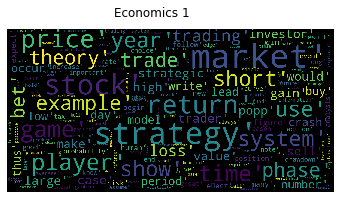

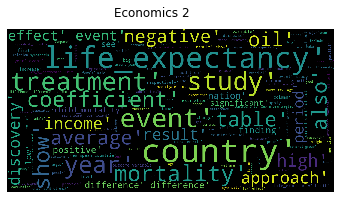

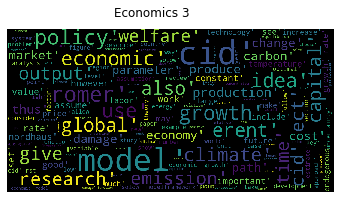

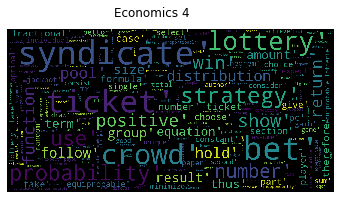

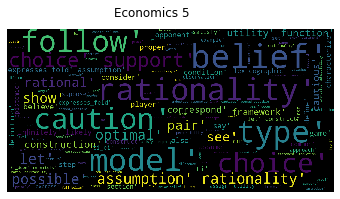

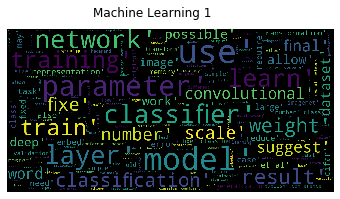

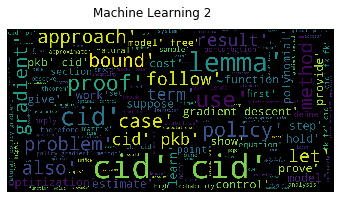

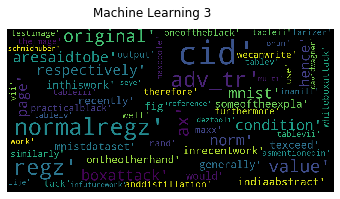

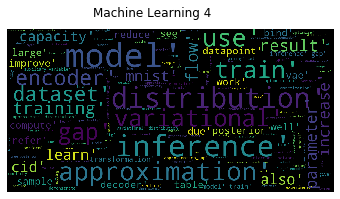

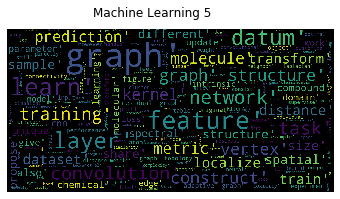

In [19]:
show_wordcloud(l0, 'Economics 1')
show_wordcloud(l1, 'Economics 2')
show_wordcloud(l2, 'Economics 3')
show_wordcloud(l3, 'Economics 4')
show_wordcloud(l4, 'Economics 5')

show_wordcloud(l5, 'Machine Learning 1')
show_wordcloud(l6, 'Machine Learning 2')
show_wordcloud(l7, 'Machine Learning 3')
show_wordcloud(l8, 'Machine Learning 4')
show_wordcloud(l9, 'Machine Learning 5')

# Preparing data for LDA analysis
*Transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.*

*We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.*

### Create the Dictionary and Corpus needed for Topic Modeling

*The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.*

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 2), (6, 3), (7, 3), (8, 1), (9, 3), (10, 8), (11, 2), (12, 1), (13, 1), (14, 1), (15, 13), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 3), (22, 3), (23, 1), (24, 6), (25, 1), (26, 1), (27, 3), (28, 1), (29, 2), (30, 1), (31, 1), (32, 5), (33, 4), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 3), (40, 6), (41, 1), (42, 2), (43, 2), (44, 7), (45, 1), (46, 11), (47, 3), (48, 1), (49, 18), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 2), (56, 2), (57, 1), (58, 1), (59, 7), (60, 3), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 4), (70, 1), (71, 2), (72, 1), (73, 1), (74, 2), (75, 2), (76, 1), (77, 3), (78, 2), (79, 1), (80, 1), (81, 6), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 4), (90, 1), (91, 3), (92, 1), (93, 3), (94, 11), (95, 2), (96, 1), (97, 2), (98, 3), (99, 1), (100, 1), (101, 1), (102, 2), (103, 3), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 2), (110

*Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).*

*For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.*

*This is used as the input by the LDA model.*

*If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.*

In [21]:
id2word[1]

'able'

*Or, you can see a human-readable form of the corpus itself.*

In [22]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abbreviation', 1),
  ('able', 1),
  ('abrupt', 1),
  ('absence', 2),
  ('accelerate', 2),
  ('acceleration', 2),
  ('accept', 3),
  ('acceptable', 3),
  ('access', 1),
  ('accord', 3),
  ('account', 8),
  ('accounting', 2),
  ('accurate', 1),
  ('achieve', 1),
  ('acknowledge', 1),
  ('action', 13),
  ('activity', 1),
  ('actual', 1),
  ('actually', 1),
  ('additional', 2),
  ('address', 2),
  ('adjust', 3),
  ('adjustment', 3),
  ('advance', 1),
  ('advantage', 6),
  ('advise', 1),
  ('agency', 1),
  ('aggregate', 3),
  ('ago', 1),
  ('agreement', 2),
  ('air', 1),
  ('akin', 1),
  ('algorithm', 5),
  ('algorithmic', 4),
  ('algorithmically', 1),
  ('alia', 1),
  ('align', 1),
  ('alike', 1),
  ('allege', 1),
  ('allocation', 3),
  ('allow', 6),
  ('allowance', 1),
  ('alone', 2),
  ('already', 2),
  ('also', 7),
  ('alternative', 1),
  ('always', 11),
  ('amount', 3),
  ('analog', 1),
  ('analysis', 18),
  ('analyst', 1),
  ('analytic', 1),
  ('analytical', 1),
  ('analytically',

*Alright, without digressing further let’s jump back on track with the next step: Building the topic model.*

### Building the Topic Model

*We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.*

*Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.*

*chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.*

In [23]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model

*The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.*

*You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.*

In [24]:
# Print the Keyword in the 15 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.001*"model" + 0.001*"use" + 0.001*"set" + 0.000*"datum" + 0.000*"result" '
  '+ 0.000*"number" + 0.000*"function" + 0.000*"show" + 0.000*"probability" + '
  '0.000*"learn"'),
 (1,
  '0.015*"use" + 0.010*"function" + 0.009*"network" + 0.008*"model" + '
  '0.008*"noise" + 0.007*"number" + 0.007*"result" + 0.006*"layer" + '
  '0.006*"ticket" + 0.006*"dataset"'),
 (2,
  '0.011*"life_expectancy" + 0.011*"event" + 0.010*"country" + 0.009*"model" + '
  '0.008*"attack" + 0.008*"apply" + 0.008*"system" + 0.008*"effect" + '
  '0.008*"study" + 0.008*"datum"'),
 (3,
  '0.066*"cid" + 0.013*"lemma" + 0.011*"proof" + 0.010*"function" + '
  '0.010*"use" + 0.009*"gradient" + 0.009*"method" + 0.008*"model" + '
  '0.007*"policy" + 0.007*"graph"'),
 (4,
  '0.022*"model" + 0.016*"set" + 0.013*"distribution" + 0.012*"inference" + '
  '0.011*"training" + 0.010*"probability" + 0.009*"train" + 0.008*"use" + '
  '0.008*"problem" + 0.008*"learn"'),
 (5,
  '0.014*"market" + 0.011*"strategy" + 0.008*"sto

*How to interpret this?*

*Topic 0 is a represented as 0.001*"model" + 0.001*"use" + 0.001*"set" + 0.000*"datum" + 0.000*"result" '
  '+ 0.000*"number" + 0.000*"function" + 0.000*"show" + 0.000*"probability" + '
  '0.000*"learn"
  
*It means the top 10 keywords that contribute to this topic are: ‘model’, ‘use’, ‘set’.. and so on and the weight of ‘model’ on topic .001.

*The weights reflect how important a keyword is to that topic.*

*Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.*

*Likewise, can you go through the remaining topic keywords and judge what the topic is?*

### Compute Model Perplexity and Coherence Score

*Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.*

In [25]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.285588972730814

Coherence Score:  0.37147951943820445


*There you have a coherence score of 0.52.*

# Analyzing LDA model result

### Visualize the topics
*Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.*

### Analyzing LDA model results
Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

	.	Better understanding and interpreting individual topics, and
	.	Better understanding the relationships between the topics.

**For (1)**  *you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.*

**For (2)** *exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.*

### **PyLDAviz visualization** feature presents three important features: 

**First** the circles on the left side represent numbered topics that were extracted from the corpus and the size of each circle represents that topic’s prevalence within the corpus.  Topics are sorted in order of a topic circle's prevalence or size.

**Second** the distance between two topic circles represents the topic’s relative similarity in a 2-dimensional representation although these distances in are representing multi-dimensional distances in the TOPIC X WORD matrix.  

**Third** on the right side are the top 30 most relevant words per topic.  The red bar represents the terms appearance in the current topic versus the blue bar which represents the term frequency thorough all topics.  Note that the value of lama in the LDA model strikes a balance between emphasizing “jargon” particular to the currently selected topic versus “laymen” oriented terms which are shared between topics.  Adjusting lambda will reorder the list of relevant terms adjusted for the current balance between these two options.  Increasing lambda will make the topic more readable to a layman.  Also, hovering over a particular word in the term list will display the topic circles for which that term is most prevalent.

In [26]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

//anaconda3/envs/jupyterlab/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.130325  0.037031       1        1  20.746262
10     0.075930 -0.177698       2        1  17.222155
2      0.106493 -0.047285       3        1  11.807212
9      0.115354  0.128518       4        1  11.131914
4      0.149213  0.063708       5        1  10.397381
3      0.151192 -0.025120       6        1  10.270356
5      0.023328 -0.138544       7        1  10.138100
6      0.066897  0.008363       8        1   4.804429
11     0.057861  0.086368       9        1   3.478735
8     -0.120516  0.020211      10        1   0.000607
0     -0.147713  0.011640      11        1   0.000583
7     -0.158575  0.008904      12        1   0.000569
13    -0.149126  0.006768      13        1   0.000568
12    -0.146535  0.008129      14        1   0.000567
14    -0.154128  0.009009      15        1   0.000566, topic_info=     Category        Freq         Term       Total  loglift  logprob
218   Default  906.000000          cid  906.000000  30.0000  30.0000
911   Default  722.000000        model  722.000000  29.0000  29.0000
572   Default  239.000000      feature  239.000000  28.0000  28.0000
5720  Default  114.000000      patient  114.000000  27.0000  27.0000
3516  Default  119.000000      cluster  119.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
1123  Topic15    0.000110  probability  178.872910  -2.2181  -8.1151
1901  Topic15    0.000106       policy  137.100037  -1.9945  -8.1575
342   Topic15    0.000112        datum  227.987259  -2.4422  -8.0965
804   Topic15    0.000112        learn  264.781067  -2.5984  -8.1031
796   Topic15    0.000107        large  170.332764  -2.1946  -8.1405

[1059 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4777      1  0.072119     abnormal
4777      3  0.829368     abnormal
4777      4  0.036059     abnormal
4777      9  0.072119     abnormal
5365      9  0.717405  abnormality
...     ...       ...          ...
1625      7  0.896035     ﬁnancial
5850      2  0.673845        ﬁscal
1637      3  0.246376          ﬂow
1637      5  0.657002          ﬂow
1637      7  0.082125          ﬂow

[1835 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 3, 10, 5, 4, 6, 7, 12, 9, 1, 8, 14, 13, 15])

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

# Conclusions

**Vikas, you can either add a conclusion from one or all of the models here, or attempt the remainder of the modeling below and then conclude.**

### Building LDA Mallet Model

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [27]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

CalledProcessError: Command 'path/to/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/vq/rv3h5zq95ns84_cgsjptyq9h0000gn/T/998bf8_corpus.txt --output /var/folders/vq/rv3h5zq95ns84_cgsjptyq9h0000gn/T/998bf8_corpus.mallet' returned non-zero exit status 127.

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

Just by changing the LDA algorithm, we increased the coherence score from .53 to .63. Not bad!

### How to find the optimal number of topics for LDA?

*My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.*

*Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.*

*If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.*

*The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.*

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, 
    corpus=corpus, 
    texts=data_lemmatized, 
    start=2, 
    limit=40, 
    step=6
)

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

*If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.*

*So for further steps I will choose the model with 20 topics itself.*

In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

*Those were the topics for the chosen LDA model.*

### Finding the dominant topic in each sentence

*One of the practical application of topic modeling is to determine what topic a given document is about.*

*To find that, we find the topic number that has the highest percentage contribution in that document.*

*The format_topics_sentences() function below nicely aggregates this information in a presentable table.*

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

### Find the most representative document for each topic

*Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!*

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

### Topic distribution across documents

*Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.*

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

In [ ]:
### 21. Conclusion

*We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.*

*Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.*

*Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.*

*Edit: I see some of you are experiencing errors while using the LDA Mallet and I don’t have a solution for some of the issues. So, I’ve implemented a workaround and more useful topic model visualizations. Hope you will find it helpful.*